# Non-blind-deconvolution

To do non-blind-deconvolution with custom PSF, we will chose PSF paramteres and save images to make dataset for training Neural network model


## 1. Problem

Non blind deconvolution
we have blure image and the kernel that has been used to be blured, we need to get the laten image 
y = k ∗ x + n

* y ∈ R^m : blurred image 
* k ∈ R^l : corresponding blur kernel k
* x ∈ R^n : latent image  
* ∗ denotes the convolution operator
* n ∈ R^m : denotes an i.i.d. white Gaussian noise term with unknown standard deviation (i.e. noise level).

givin y and k, we need to estimate x

k is the psf of an eye of individuals having refractive vision problems. !

we will make  k (psf) and generate y images


## 2. Data

The data we're using till now: *DATASET FROM HRTR: http://chaladze.com/l5/* 
//could be updated later


## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* We're generating dataset : blur kernel k, and n noise , and then y by ourself   
* 
* . 


In [1]:
#path for dataset folder:
DATA_DIR = "dataFiles/Linnaeus 5 256X256/"

#num_params for psf - for sweet project that makes psf 
num_params=5 # or 20 later! 

#path for already trained models folder:
MODEL_DIR='trainedModels/'

#folder to save psf parameters 
save_psf_parameter_folder = 'psf_parameters/'

#psf is shifted from sweet project 
SHIFT = True

### Get our workspace ready

* Reload all modules (except those excluded by %aimport) automatically now. '%autoreload'
* Reload all modules (except those excluded by %aimport) every time before executing the Python code typed. '%autoreload 2' ✅
* Import torch=1.10 ✅
* Make sure we're using a GPU ✅
* install lib  pydoe, torchsummary, torchmetrics, piq ✅


In [2]:
%load_ext autoreload
%autoreload 2 

In [3]:
%reload_ext autoreload

In [6]:
# #install necessary tools / either this cell or next
# ! pip install -r requirements.txt

In [2]:
#install necessary tools
# !pip install pydoe -q
# !pip install torchsummary -q
# !pip install torchmetrics -q
# !pip install piq -q


# !pip install torch==1.10 
 

In [2]:
# Import necessary tools
import torch

# from __future__ import print_function, absolute_import
import torch
import os
# import scipy.io as sio
from torch.utils.data import Dataset, DataLoader
import numpy as np
# from data.make_kernel import kernel_sim_spline
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
from pathlib import Path
# from operator import itemgetter
from skimage.color import rgb2gray
import pyDOE as doe # LHS
from scipy.stats.distributions import uniform
from tqdm import tqdm
# from skimage import util, filters
# from scipy import signal

from PIL import Image
import pandas as pd
import numpy as np
from skimage import io , img_as_ubyte

from sweet.sweet import Sweet
from sweet.util.fft import shift, fft_conv

from sklearn.model_selection import train_test_split

#import the NNmodel for our training
from NNmodels.model_rgdn import OptimizerRGDN


# import the evalution function
from skimage.metrics import structural_similarity as ssim

print("pytorch version:", torch.__version__)
# 
# Check for GPU availability
print("GPU", "available (YESSSS!!!!!)" if torch.cuda.is_available() else "not available :(")

pytorch version: 1.10.0+cu102
GPU available (YESSSS!!!!!)


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [3]:
#get psf parameters 

def get_psf(S, A, C, pupil_diam):
    sweet = Sweet()
    sweet.set_eye_prescription(
        S = S, 
        A = A,
        C = C)
    sweet.set_experiment_params(
        pupil_diam = pupil_diam,  
        view_dist = 100.0,      
        canvas_size_h = 10.0)
    psf = sweet._psf()
    return psf

In [4]:
#fixed parameters for psf 

fixed_params = {
    'pupil_diam' : 2.5,
    'A' : 0
    
    # order: S[-8,-4], A, C[-3,0], pupil_diam
    # for later: needs to be : S[-8,-2], C[-3,0], A[0,360 degree]
}

In [5]:
#make costumed psf 
   
      
def costumed_psf(rand_values=True,
                 S=[-4.0]*5,
                 C=[-1.5]*5,
                 sphere_first_value=-8.0,
                 sphere_scale=4,
                 Cylinder_first_value=-3.0,
                 Cylinder_scale=3.0,
                 num_params=5):
    
    
    """
    Function to get costumed psf either by scale of Sphere and sylinder values, or by excact values for S,C.
    
    :param: rand_values: boolen to determin if psf parameters are randomly generated
    :param: S: defult=[-4.0]*num_params,sphere parameter psf, considered if rand_values=False
    :param: C: defult=[-1.5]*num_params, Cylinder parameter psf, considered if rand_values=False
    :param: sphere_first_value: defult=-8, the first value S parameter takes
    :param: sphere_scale: defult=4, the scale that S can differ in 
    :param: Cylinder_first_value: defult=-3, the first value C parameter takes
    :param: Cylinder_scale: defult=3, the scale that C can differ in 
    :param: num_params: how many psf sample we want 
    
    :return: list of psf
    """
    
    #num_params :how many psf sample we want 
    params = doe.lhs(4, samples=num_params) # order: S, A, C, pupil_diam
    
    #P: pupil diameter = 2.5
    params[:, 3] = fixed_params['pupil_diam']
    
    #A: angel by degrees
    params[:, 1] = fixed_params['A']
    
    if rand_values== True:
        
        #S: is random number in interval [-8,-4]
        params[:, 0] = uniform(loc=sphere_first_value, scale=sphere_scale).ppf(params[:,0])
        

        #C: is random number in interval [-3,0]
        params[:, 2] = uniform(loc=Cylinder_first_value, scale=Cylinder_scale).ppf(params[:, 2])
    else:
        #S: is exact number givin
        params[:, 0] = S

        #C: is exact number given
        params[:, 2] = C
    # round the parameters just for easy saving 
    
    params[:, 0]= [round(num, 2) for num in params[:, 0]]
    params[:, 2] = [round(num, 2) for num in params[:, 2]]
    
    params = params.tolist()

    for i in tqdm(range(num_params)):
        
        #get an 256*256 numpy array as psf
#         print("*params[i]")
#         print(*params[i])
        psf = get_psf(*params[i])
        psf = psf / psf.sum()        # ADD NORMALIZING
        # add the recieved numpy array psf to list 
        params[i].append(psf)
    
    
    return params


np.random.seed(42)
params=costumed_psf()        
      

    
# for param in params:
#     for p in param:
#         print(str(p))
#     print('\n')
            
print (len(params))
params

100%|██████████| 5/5 [00:00<00:00,  6.45it/s]

5


[[-7.7,
  0.0,
  -2.56,
  2.5,
  array([[0.00060488, 0.00057969, 0.00061882, ..., 0.00059873, 0.00058937,
          0.00061629],
         [0.00061906, 0.00060199, 0.00060567, ..., 0.00057391, 0.00063145,
          0.0006401 ],
         [0.00064788, 0.00059155, 0.00055899, ..., 0.00054422, 0.00063619,
          0.0006777 ],
         ...,
         [0.00062618, 0.00059193, 0.0005692 , ..., 0.00052672, 0.0006492 ,
          0.00065611],
         [0.00059971, 0.00056621, 0.00061072, ..., 0.00059929, 0.00060396,
          0.00062084],
         [0.00060012, 0.00056077, 0.00061164, ..., 0.00060283, 0.00057126,
          0.00061016]])],
 [-4.93,
  0.0,
  -2.37,
  2.5,
  array([[0.00149893, 0.00137844, 0.00138453, ..., 0.00130915, 0.00147764,
          0.00155193],
         [0.00145207, 0.00131386, 0.00141506, ..., 0.00138553, 0.00144437,
          0.00149074],
         [0.0013927 , 0.00138037, 0.0013797 , ..., 0.00127974, 0.00154168,
          0.00140501],
         ...,
         [0.00141036, 0.

In [6]:
 

name_of_file = "psf_to_generate_blurred_images"


#save parameters for seet project
def save_params(name_of_file, params):
    completeName = os.path.join(save_psf_parameter_folder, name_of_file+".txt")             
    with open(completeName, 'a') as f:
        f.truncate(0)
        for param in params:
            for p in param:
                f.write(str(p))
                f.write('\n')
            f.write('\n+\n\n')
            
        f.close()
            

In [7]:
save_params(name_of_file, params)

In [8]:
# len(params)
for param in range(len(params)):
    print(len(params[param]))
    
for param in params:
            for p in param[:-1]:
                print(str(p))
#                 print('\n')
            print('\n')

5
5
5
5
5
-7.7
0.0
-2.56
2.5


-4.93
0.0
-2.37
2.5


-7.08
0.0
-0.34
2.5


-4.56
0.0
-1.09
2.5


-5.92
0.0
-1.79
2.5




In [9]:
#folder for every psf with its
Folder_to_save = DATA_DIR + "train_blurred_imgs/"
psf_pathes=[]
for param in params:
    
    name_of_psf_folder= f"psf_{param[:-1]}"
    path = Folder_to_save+ name_of_psf_folder 
    psf_pathes.append(path)

    # Check whether the specified path exists or not
    if not (os.path.exists(path)):
        # Create a new directory because it does not exist 
        os.makedirs(path)
        print(f"The new directory: ({path}) is created!")
    else:
        print(f"The directory: ({path}) is already existed!")

The directory: (dataFiles/Linnaeus 5 256X256/train_blurred_imgs/psf_[-7.7, 0.0, -2.56, 2.5]) is already existed!
The directory: (dataFiles/Linnaeus 5 256X256/train_blurred_imgs/psf_[-4.93, 0.0, -2.37, 2.5]) is already existed!
The directory: (dataFiles/Linnaeus 5 256X256/train_blurred_imgs/psf_[-7.08, 0.0, -0.34, 2.5]) is already existed!
The directory: (dataFiles/Linnaeus 5 256X256/train_blurred_imgs/psf_[-4.56, 0.0, -1.09, 2.5]) is already existed!
The directory: (dataFiles/Linnaeus 5 256X256/train_blurred_imgs/psf_[-5.92, 0.0, -1.79, 2.5]) is already existed!


In [10]:
psf_pathes[2]



'dataFiles/Linnaeus 5 256X256/train_blurred_imgs/psf_[-7.08, 0.0, -0.34, 2.5]'

In [11]:
#create folders for blurred images with noise 
Folder_to_save = DATA_DIR + "train_blurred_imgs/"
psf_pathes_nois=[]
for param in params:
    
    name_of_psf_folder= f"psf_{param[:-1]}_noisy"
    path = Folder_to_save+ name_of_psf_folder 
    psf_pathes_nois.append(path)

    # Check whether the specified path exists or not
    if not (os.path.exists(path)):
        # Create a new directory because it does not exist 
        os.makedirs(path)
        print(f"The new directory: ({path}) is created!")
    else:
        print(f"The directory: ({path}) is already existed!")


The directory: (dataFiles/Linnaeus 5 256X256/train_blurred_imgs/psf_[-7.7, 0.0, -2.56, 2.5]_noisy) is already existed!
The directory: (dataFiles/Linnaeus 5 256X256/train_blurred_imgs/psf_[-4.93, 0.0, -2.37, 2.5]_noisy) is already existed!
The directory: (dataFiles/Linnaeus 5 256X256/train_blurred_imgs/psf_[-7.08, 0.0, -0.34, 2.5]_noisy) is already existed!
The directory: (dataFiles/Linnaeus 5 256X256/train_blurred_imgs/psf_[-4.56, 0.0, -1.09, 2.5]_noisy) is already existed!
The directory: (dataFiles/Linnaeus 5 256X256/train_blurred_imgs/psf_[-5.92, 0.0, -1.79, 2.5]_noisy) is already existed!


In [12]:
psf_pathes_nois

['dataFiles/Linnaeus 5 256X256/train_blurred_imgs/psf_[-7.7, 0.0, -2.56, 2.5]_noisy',
 'dataFiles/Linnaeus 5 256X256/train_blurred_imgs/psf_[-4.93, 0.0, -2.37, 2.5]_noisy',
 'dataFiles/Linnaeus 5 256X256/train_blurred_imgs/psf_[-7.08, 0.0, -0.34, 2.5]_noisy',
 'dataFiles/Linnaeus 5 256X256/train_blurred_imgs/psf_[-4.56, 0.0, -1.09, 2.5]_noisy',
 'dataFiles/Linnaeus 5 256X256/train_blurred_imgs/psf_[-5.92, 0.0, -1.79, 2.5]_noisy']

In [13]:
# save in SCV file psf param, path to ground truth image, path to blurred image, path to blurred noisy image 

In [14]:
params[0][-1].shape

(256, 256)

# numpy functions to save and upload an nparray 
np.save("filename", image)

 np.load("filename.npy")


# Code to generate blurred images, noisy + not noisy 


In [15]:
# loop for the images to blurr them 
patch_size=256
imddx=0 #index for images
psfdx=0 #index for PSFs 
is_rgb= False # is imges coloured 
noise_level_interval = (0.003,0.015) # the percentage of noise levels (interval)
noise_level= None  # the percentage of noise levels (fixed value)
train_dir = Path(os.path.join(DATA_DIR, 'train')) # paths to train folders 
list_train_files_names = list(train_dir.rglob('*.jpg'))  # paths to all train images  
proceced_imgs=0  # proceced_imgess


# create an Empty pandas DataFrame to keep track of ground truth img, and blurr kernel (psf params)
df = pd.DataFrame()
df['PSF_params'] = []
df['Path_to_Ground_truth_img'] = []
df['Path_to_blurred_img'] = []
df['Path_to_blurred_img_noisy'] = []

number_of_all_images = len( list_train_files_names)
number_of_PSFs= len(params)

for imddx in tqdm(range(number_of_all_images)):
    
    
    for psfdx in range(number_of_PSFs):
#         print(psfdx, params[psfdx][:-1],proceced_imgs)
        k = params[psfdx][-1]

        img_name = list_train_files_names[imddx]
        sample = plt.imread(img_name)

        if sample.shape[0] < patch_size or sample.shape[
                1] < patch_size:
            print("ERROR, Input images expected to be of size 256x256")

        patches = image.extract_patches_2d(sample,
                                           [patch_size, patch_size],
                                           max_patches=1)
        sample = patches[0, ...]
        sample = sample.astype(np.float32) / 255.0

        if not is_rgb:
            sample = rgb2gray(sample)

        y = fft_conv(sample, k)
        y =y.astype(np.float32) 

        # plt.imshow(y)

        # save y (blurred image)
        # take the name of file and folder for GT img
        name_gt=str(list_train_files_names[imddx]).split("/")[-2]+"+"+str(list_train_files_names[imddx]).split("/")[-1]
        # name of img to save
        blurres_img_name = f"psf+{params[psfdx][:-1]}+GT+{name_gt}"

        # im = Image.fromarray(y)
        path_to_save_blurred= psf_pathes[psfdx]+'/'+ blurres_img_name

        #save the blurred image

        #as np.array to get the same exact values
        np.save(path_to_save_blurred, y)

        #as img just for visulsaiton the files in case it's needed 
        io.imsave(os.path.join(psf_pathes[psfdx],blurres_img_name),img_as_ubyte(y))



        # add noise:

        ytensor_noisy = torch.tensor(y, dtype=torch.float32).unsqueeze(0)

        #       #adding noise nl
        nl=0.0 #if no noise_level added it will be 0 
        if noise_level_interval is not None:
            nl = np.random.uniform(noise_level_interval[0], noise_level_interval[1])  #0.3% - 1.5%

        elif noise_level is not None:
            nl = self.noise_level

        #add noise to blurred image 
        ytensor_noisy = ytensor_noisy + nl * torch.randn_like(ytensor_noisy)
        ytensor_noisy = torch.clamp(ytensor_noisy * 255.0, 0, 255)
        ytensor_noisy = ytensor_noisy.type(torch.ByteTensor)
        ytensor_noisy = ytensor_noisy.float() / 255.0
        
#         #some steps from articel 
#         hks=6//2
#         ytensor_noisy = torch.nn.functional.pad(ytensor_noisy, (hks, hks, hks, hks),
#                                         mode='replicate')
#         ytensor_noisy = ytensor_noisy.squeeze(1)    
        
        
        #numpy array of noisy blurred img tensor
        y_np_noisy=(ytensor_noisy[0, :, :].squeeze(0).cpu().numpy())

        # name of blurred img to save, will be psf params & GT name
        blurres_img_name_noisy = f"psf+{params[psfdx][:-1]}+noisy+GT+{name_gt}"

        path_to_save_blurred_noisy= psf_pathes_nois[psfdx]+'/'+ blurres_img_name_noisy


        #save the noisy blurred image

        #as np.array to get the same exact values
        np.save(path_to_save_blurred_noisy, y_np_noisy)
        #as img just for visulsaiton the files in case it's needed 
#         print(np.max(y_np_noisy), np.min(y_np_noisy))
#         print(y_np_noisy.shape, y_np_noisy.size)
        
        io.imsave(os.path.join(psf_pathes_nois[psfdx],blurres_img_name_noisy),img_as_ubyte(y_np_noisy))



        # save psf param, path to ground truth image, path to blurred image, path to blurred noisy image in csv file

        df=df.append({'PSF_params' : params[psfdx],
                      'Path_to_Ground_truth_img': str(list_train_files_names[imddx]),
                      'Path_to_blurred_img': path_to_save_blurred,
                     'Path_to_blurred_img_noisy':path_to_save_blurred_noisy },
                      ignore_index = True)
        
        proceced_imgs+=1
        

    #  save the dataframe intofile
df.to_csv('psf_GT_blurred.csv')


    #an early stop condition if needed, to check the first batch of images
#     if proceced_imgs> 10:
#         break

 89%|████████▉ | 5360/6000 [17:36<01:55,  5.55it/s]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: dataFiles/Linnaeus 5 256X256/train_blurred_imgs/psf_[-7.7, 0.0, -2.56, 2.5]/psf+[-7.7, 0.0, -2.56, 2.5]+GT+other+496_256.jpg is a low contrast image
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: dataFiles/Linnaeus 5 256X256/train_blurred_imgs/psf_[-4.93, 0.0, -2.37, 2.5]/psf+[-4.93, 0.0, -2.37, 2.5]+GT+other+496_256.jpg is a low contrast image
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: dataFiles/Linnaeus 5 256X256/train_blurred_imgs/psf_[-7.08, 0.0, -0.34, 2.5]/psf+[-7.08, 0.0, -0.34, 2.5]+GT+other+496_256.jpg is a low contrast image
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: dataFiles/Linnaeus 5 256X256/train_blurred_imgs/psf_[-5.92, 0.0, -1.79, 2.5]/psf+[-5.92, 0.0, -1.79, 2.5]+GT+other+496_256.jpg is a low contrast image
 91%|█████████▏| 5475/6000 [17:58<0

In [24]:
np_img_name="psf+[-7.7, 0.0, -2.56, 2.5]+GT+other+496_256.jpg.npy"
path= "dataFiles/Linnaeus 5 256X256/train_blurred_imgs/psf_[-7.7, 0.0, -2.56, 2.5]/"

In [30]:
c= np.load(path+np_img_name)
c

array([[0.7134178 , 0.7125409 , 0.7117141 , ..., 0.71609795, 0.7153456 ,
        0.714418  ],
       [0.7130151 , 0.712272  , 0.7115778 , ..., 0.7158217 , 0.71496105,
        0.7139664 ],
       [0.71275175, 0.71185315, 0.7112328 , ..., 0.7156156 , 0.7147911 ,
        0.71380985],
       ...,
       [0.71473086, 0.7140088 , 0.7131734 , ..., 0.71671623, 0.71607006,
        0.71534604],
       [0.7141607 , 0.7132933 , 0.7123954 , ..., 0.716589  , 0.7159352 ,
        0.71513647],
       [0.71382797, 0.7128165 , 0.7119439 , ..., 0.7163395 , 0.7156233 ,
        0.71478516]], dtype=float32)

0.7501739 0.7021136


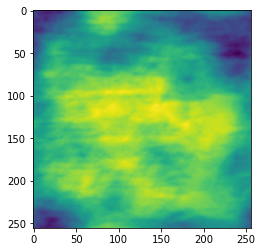

In [31]:
plt.imshow(c)
print(np.max(c), np.min(c))

In [386]:
256//2.0

128.0

In [17]:
proceced_imgs

30000

In [32]:
df['Path_to_blurred_img'].count

<bound method Series.count of 0        dataFiles/Linnaeus 5 256X256/train_blurred_img...
1        dataFiles/Linnaeus 5 256X256/train_blurred_img...
2        dataFiles/Linnaeus 5 256X256/train_blurred_img...
3        dataFiles/Linnaeus 5 256X256/train_blurred_img...
4        dataFiles/Linnaeus 5 256X256/train_blurred_img...
                               ...                        
29995    dataFiles/Linnaeus 5 256X256/train_blurred_img...
29996    dataFiles/Linnaeus 5 256X256/train_blurred_img...
29997    dataFiles/Linnaeus 5 256X256/train_blurred_img...
29998    dataFiles/Linnaeus 5 256X256/train_blurred_img...
29999    dataFiles/Linnaeus 5 256X256/train_blurred_img...
Name: Path_to_blurred_img, Length: 30000, dtype: object>

In [40]:
df.tail()

,PSF_params,Path_to_Ground_truth_img,Path_to_blurred_img,Path_to_blurred_img_noisy
29995,"[-7.7, 0.0, -2.56, 2.5, [[0.000604876734375065...",dataFiles/Linnaeus 5 256X256/train/other/995_2...,dataFiles/Linnaeus 5 256X256/train_blurred_img...,dataFiles/Linnaeus 5 256X256/train_blurred_img...
29996,"[-4.93, 0.0, -2.37, 2.5, [[0.00149893011150010...",dataFiles/Linnaeus 5 256X256/train/other/995_2...,dataFiles/Linnaeus 5 256X256/train_blurred_img...,dataFiles/Linnaeus 5 256X256/train_blurred_img...
29997,"[-7.08, 0.0, -0.34, 2.5, [[0.00108027589490736...",dataFiles/Linnaeus 5 256X256/train/other/995_2...,dataFiles/Linnaeus 5 256X256/train_blurred_img...,dataFiles/Linnaeus 5 256X256/train_blurred_img...
29998,"[-4.56, 0.0, -1.09, 2.5, [[0.00216508556400213...",dataFiles/Linnaeus 5 256X256/train/other/995_2...,dataFiles/Linnaeus 5 256X256/train_blurred_img...,dataFiles/Linnaeus 5 256X256/train_blurred_img...
29999,"[-5.92, 0.0, -1.79, 2.5, [[0.00111462496627701...",dataFiles/Linnaeus 5 256X256/train/other/995_2...,dataFiles/Linnaeus 5 256X256/train_blurred_img...,dataFiles/Linnaeus 5 256X256/train_blurred_img...


In [41]:
print(df['Path_to_blurred_img'][0])

dataFiles/Linnaeus 5 256X256/train_blurred_imgs/psf_[-7.7, 0.0, -2.56, 2.5]/psf+[-7.7, 0.0, -2.56, 2.5]+GT+berry+1012_256.jpg


In [42]:
print(f"There are {proceced_imgs} processe images")

There are 30000 processe images
